# Using archetypal analysis to find representative cells & describe heterogeniety in hepatocyte population between those archetypes

Adapted from the Vignette `Hepatocyte_example.html` (see https://vitkl.github.io/ParetoTI/articles/Hepatocyte_example.html) from the R package `ParetoTI` by Vitalii Kleshchevnikov

Here we look at mouse hepatocytes profiles by scRNA-seq from [1]. The data are from a study by Shalev Itzkovitz where they found that about 50% of the genes expression in hepatocytes exhibit a zonation gradient in liver lobules.

The data was then used by Miri Adler et al. (see [2]) to ...

[1] Halpern, K. B. et al. Single-cell spatial reconstruction reveals global division of labour in the mammalian liver. Nature 542, 352–356 (2017)
  
[2] Adler, M., Kohanim, Y. K., Tendler, A., Mayo, A. & Alon, U. Continuum of Gene-Expression Profiles Provides Spatial Division of Labor within a Differentiated Cell Type. Cell Syst. 8, 43-52.e5 (2019)

In [ ]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as pn
import scanpy as sc
from sklearn.decomposition import PCA

sys.path.append("..")
from partipy.arch import AA
from partipy.paretoti_funcs import *

dark_theme = pn.theme_dark() + pn.theme(
    rect=pn.element_rect(color="black", fill="black"),
    axis_text=pn.element_text(color="white"),
    legend_text=pn.element_text(color="white"),
    legend_title=pn.element_text(color="white"),
    axis_title=pn.element_text(color="white"),
    plot_title=pn.element_text(color="white"),
    subplots_adjust={"wspace": 0.20},
)

plt.style.use("dark_background")

# ignore future warnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Questions:

- Should we clip the z-scores?
- Should we use more genes?

In [2]:
random_state = 42
scale_factor = 1e4
clip_z_scores = np.inf  # not done in the paper
n_hvg = 522  # as specified in the paper
n_pcs = 7  # as specified in the paper
n_archetypes = 4  # as specified in the paper

In [3]:
adata = sc.read_h5ad("../data/hepatocytes.h5ad")

adata.var["mt"] = adata.var_names.str.startswith("mt-")
adata.var["alb"] = adata.var_names.str.startswith("Alb")

adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["n_genes_nonzero"] = (adata.X != 0).sum(axis=1)
adata.obs["alb_frac"] = adata[:, adata.var["alb"]].X.sum(axis=1) / adata.obs["n_counts"]
adata.obs["mt_frac"] = adata[:, adata.var["mt"]].X.sum(axis=1) / adata.obs["n_counts"]

# remove batches of different cells (probably non-hepatocytes)
adata = adata[~adata.obs["batch"].isin(["AB630", "AB631"])].copy()

# only keep cells that have more than 1_000 and less than 30_000 UMI counts
adata = adata[adata.obs["n_counts"] > 1_000, :].copy()
adata = adata[adata.obs["n_counts"] < 30_000, :].copy()

# only keep cells that have a albumin count fraction of at least 1%
adata = adata[adata.obs["alb_frac"] > 0.01, :].copy()

# only keep genes that are expressed in at least 5% of the cells
adata.var["frac_nonzero"] = (adata.X != 0).mean(axis=0)
adata = adata[:, adata.var["frac_nonzero"] > 0.05].copy()

# only keep cells that express at least 15% of the remaining genes
adata = adata[(adata.X != 0).mean(axis=1) > 0.15, :].copy()

adata.layers["scaled_fracs"] = (
    adata.X / adata.X.sum(axis=1, keepdims=True) * scale_factor
)
assert np.all(np.isclose(adata.layers["scaled_fracs"].sum(axis=1), scale_factor))

adata.layers["log1p"] = np.log1p(adata.layers["scaled_fracs"])
z_scores = adata.layers["log1p"] - adata.layers["log1p"].mean(axis=0, keepdims=True)
z_scores = z_scores / z_scores.std(axis=0, keepdims=True)
assert np.all(np.isclose(z_scores.mean(axis=0), 0))
assert np.all(np.isclose(z_scores.std(axis=0), 1))
z_scores[z_scores > clip_z_scores] = clip_z_scores
z_scores[z_scores < -clip_z_scores] = -clip_z_scores
adata.layers["z_scores"] = z_scores
adata

AnnData object with n_obs × n_vars = 1224 × 7269
    obs: 'batch', 'well', 'seq_batch_ID', 'plate_coordinates', 'pool_barcode', 'cell_barcode', 'plate', 'subject', 'perc.mito', 'n_counts', 'n_genes_nonzero', 'alb_frac', 'mt_frac'
    var: 'mt', 'alb', 'frac_nonzero'
    uns: 'X_name'
    layers: 'scaled_fracs', 'log1p', 'z_scores'

# Highly Variable Genes

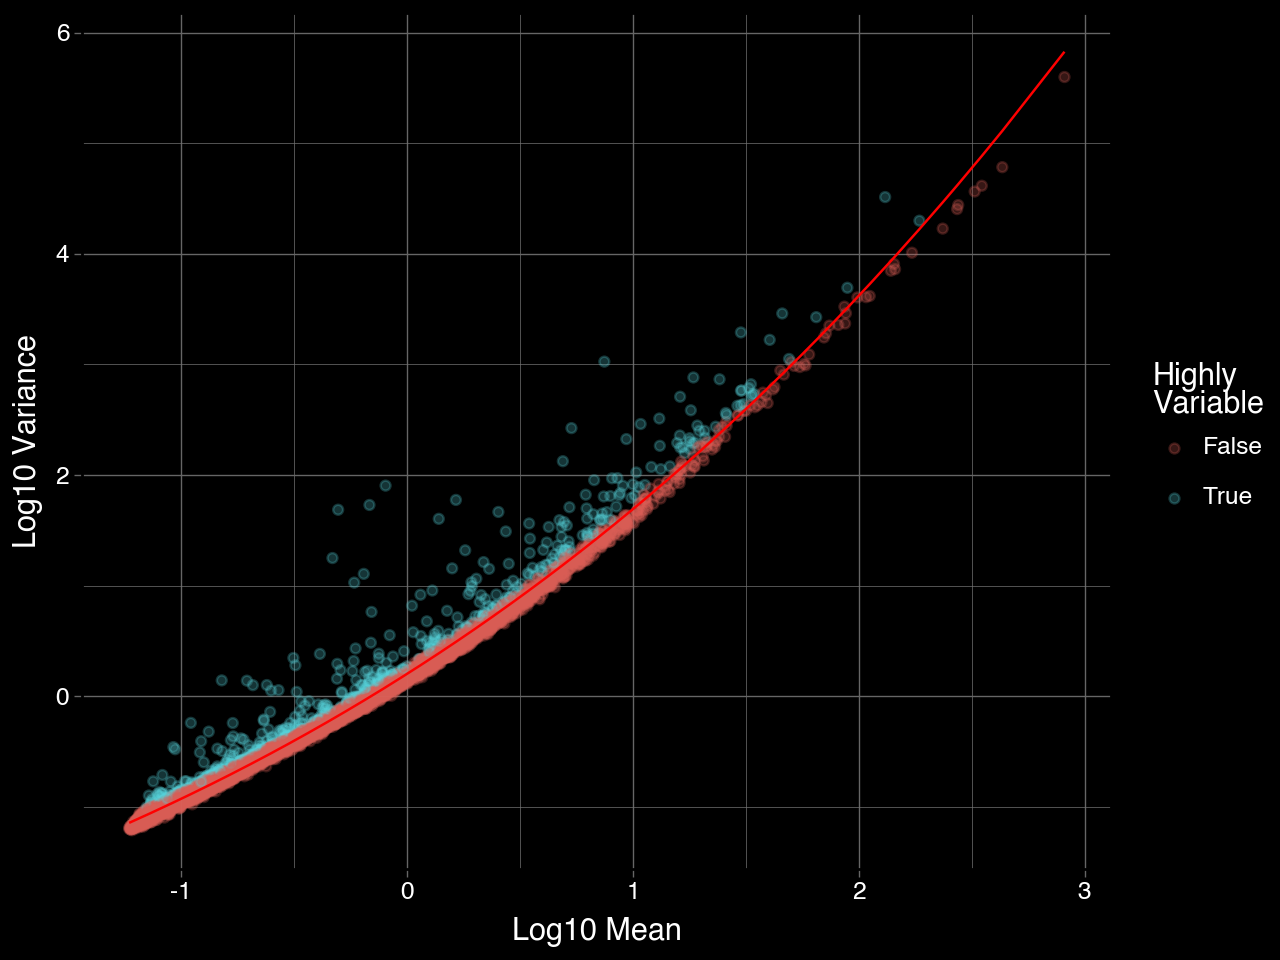

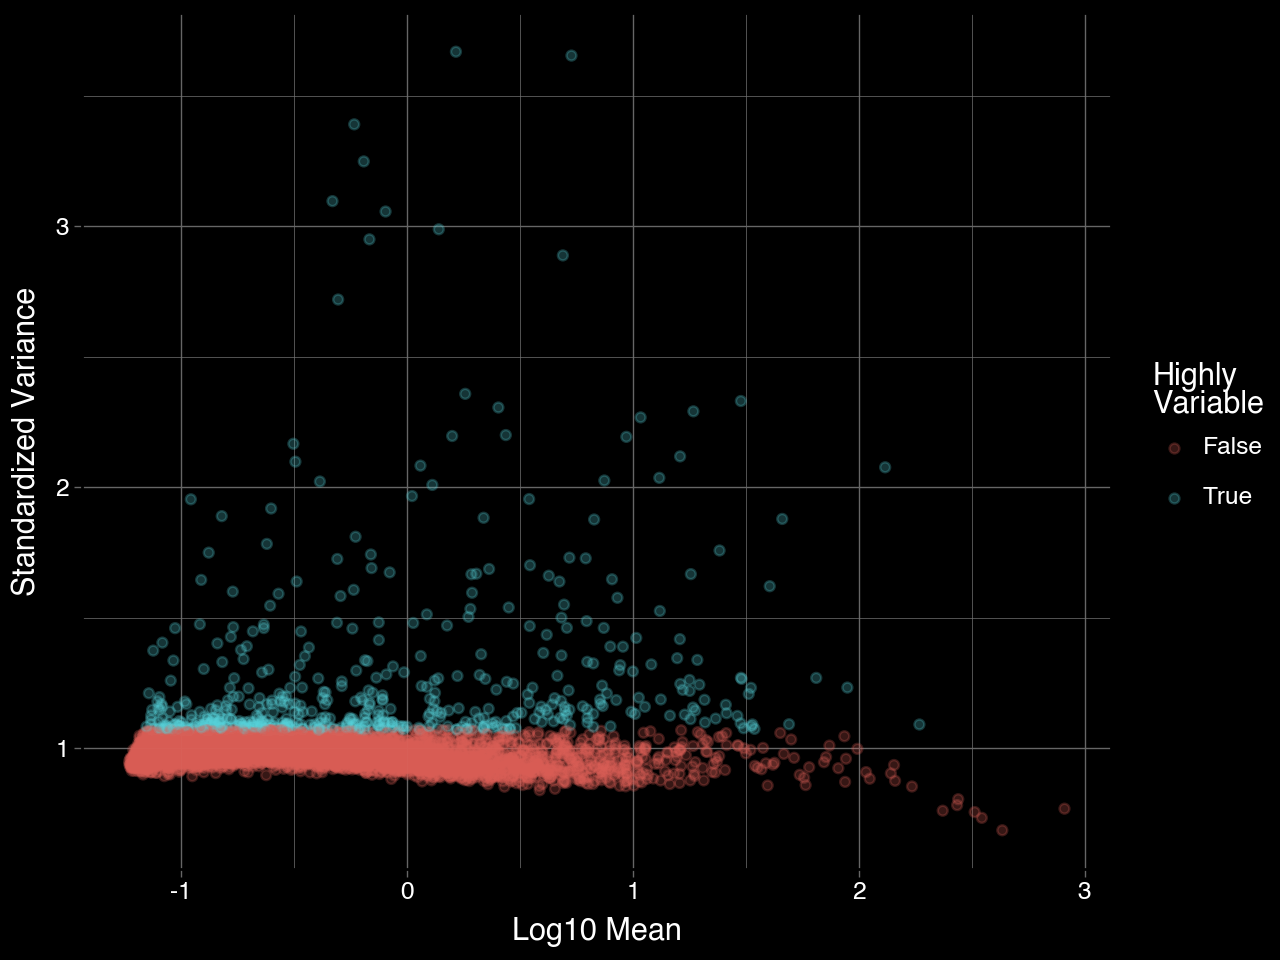

In [4]:
# get highly variable genes
hvg_vst_method(adata)
adata.var["hvg"] = adata.var["std_variance_rank"] < n_hvg

p = (
    pn.ggplot(adata.var)
    + pn.geom_point(pn.aes(x="log10_mean", y="log10_variance", color="hvg"), alpha=0.25)
    + pn.geom_line(pn.aes(x="log10_mean", y="log10_predicted_variance"), color="red")
    + pn.labs(x="Log10 Mean", y="Log10 Variance", color="Highly\nVariable")
    + dark_theme
)
p.show()

p = (
    pn.ggplot(adata.var)
    + pn.geom_point(pn.aes(x="log10_mean", y="std_variance", color="hvg"), alpha=0.25)
    + pn.labs(x="Log10 Mean", y="Standardized Variance", color="Highly\nVariable")
    + dark_theme
)
p.show()

# Principal Component Analysis

- As in the paper we will use z-scores of log1p transformed count fractions as input to PCA.

- As in the paper, we will use the 7 first principal compnents

- Note, in the paper it says that the first 3 components explain 17% of the variance, here it is not exactly the same

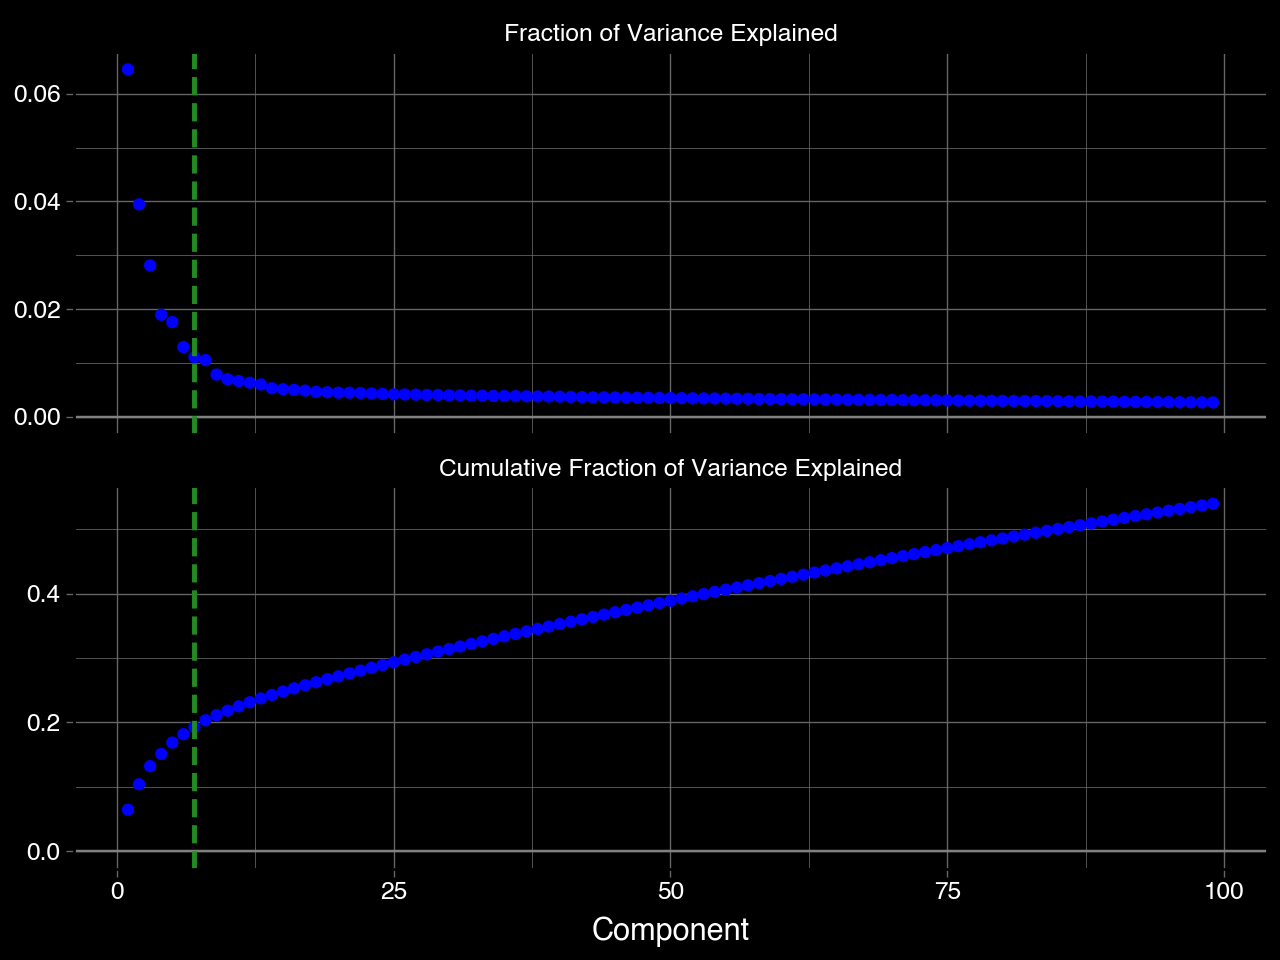

In [5]:
(
    get_var_explained_pca(
        adata[:, adata.var["hvg"]].layers["z_scores"].copy(), max_comp=100
    )
    + pn.geom_vline(xintercept=n_pcs, color="forestgreen", linetype="dashed", size=1)
    + dark_theme
)

In [6]:
pca = PCA(random_state=random_state).fit(
    X=adata[:, adata.var["hvg"]].layers["z_scores"].copy()
)
B = pca.components_.T
Z = (adata[:, adata.var["hvg"]].layers["z_scores"].copy() - pca.mean_) @ B
assert np.all(
    np.isclose(Z, pca.transform(adata[:, adata.var["hvg"]].layers["z_scores"].copy()))
)
if clip_z_scores == np.inf:
    assert np.all(np.isclose(pca.mean_, 0))
# del pca
adata.obsm["Z_pca"] = Z
X = adata.obsm["Z_pca"][:, :n_pcs]
X.shape

(1224, 7)

# Determine the Number of Archtypes

1. The Fraction of Variance Explained by different number of Archetypes

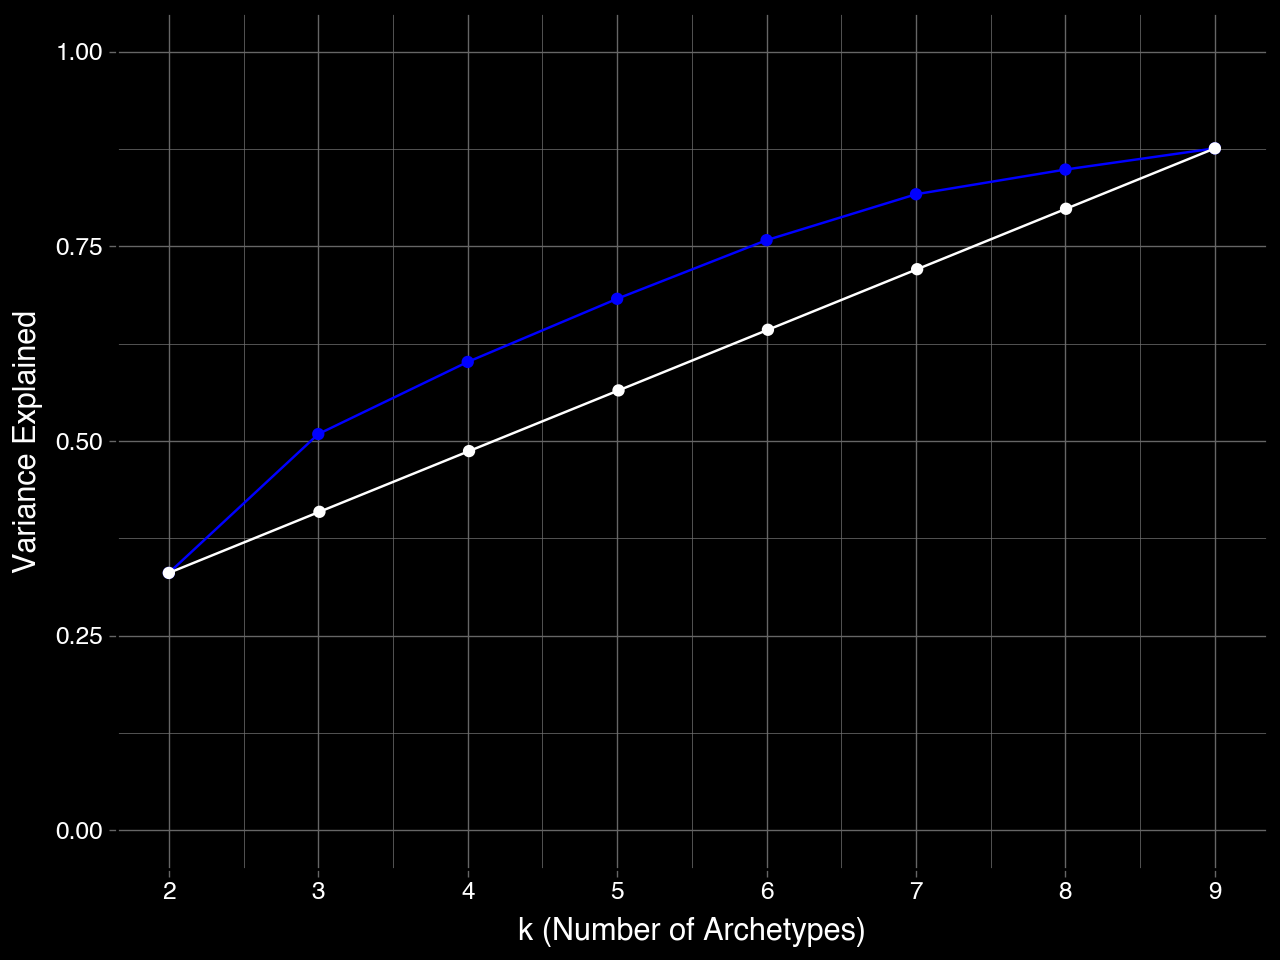

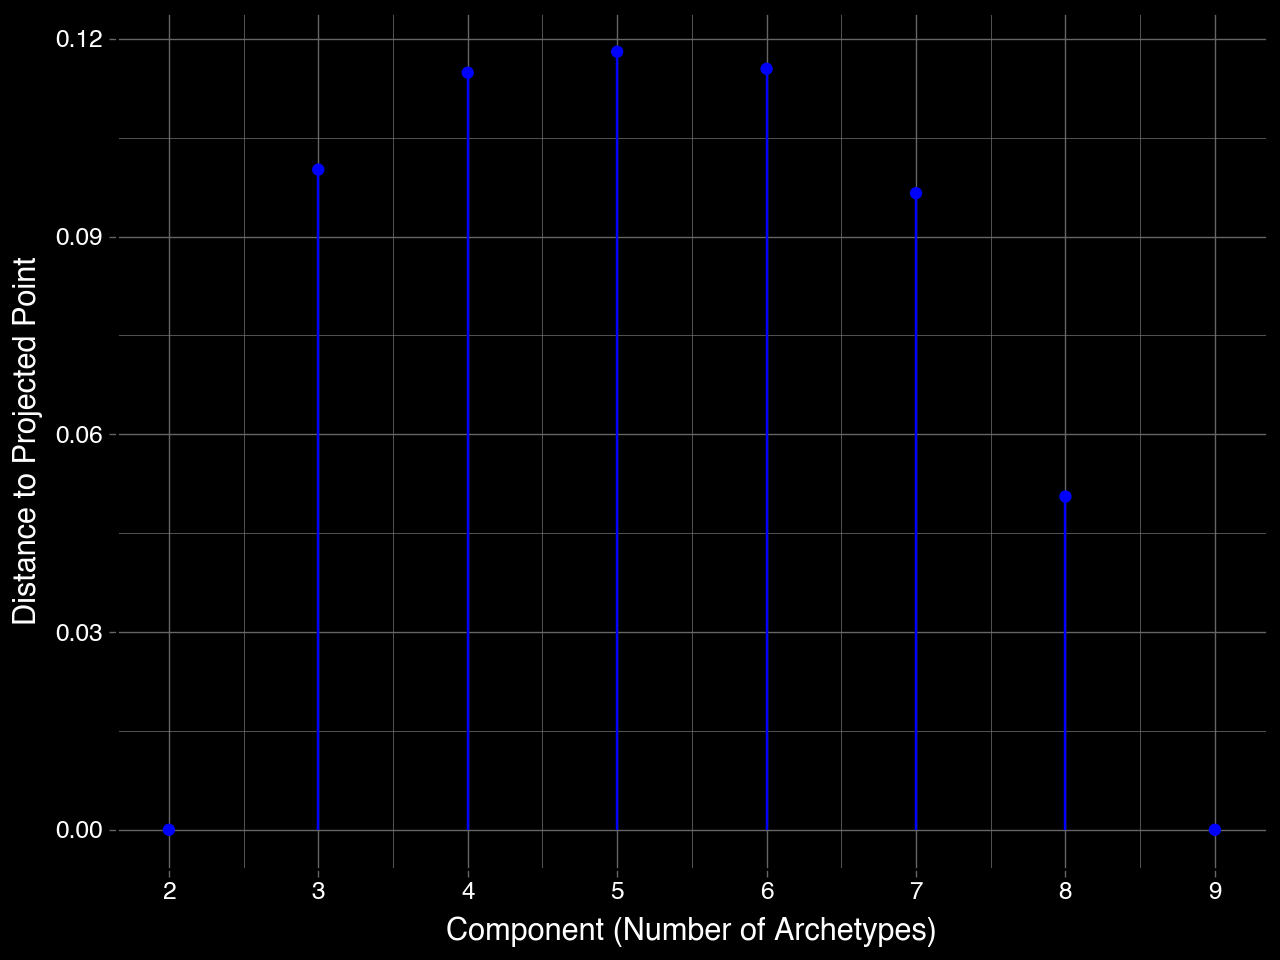

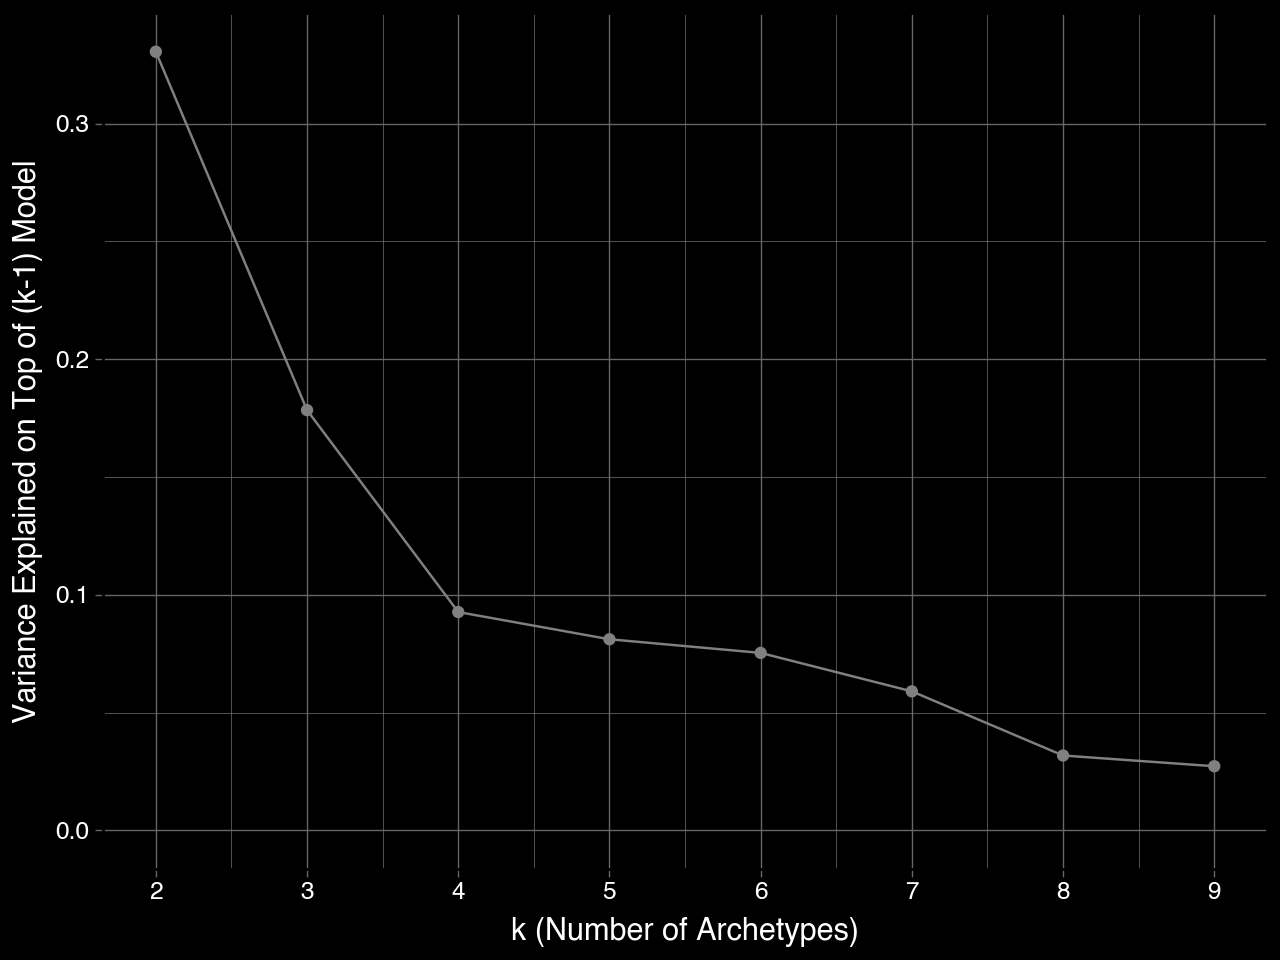

In [7]:
p1, p2, p3 = get_var_explained_aa(X)
(p1 + dark_theme).show()
(p2 + dark_theme).show()
(p3 + dark_theme).show()

2. Bootstrap Variance

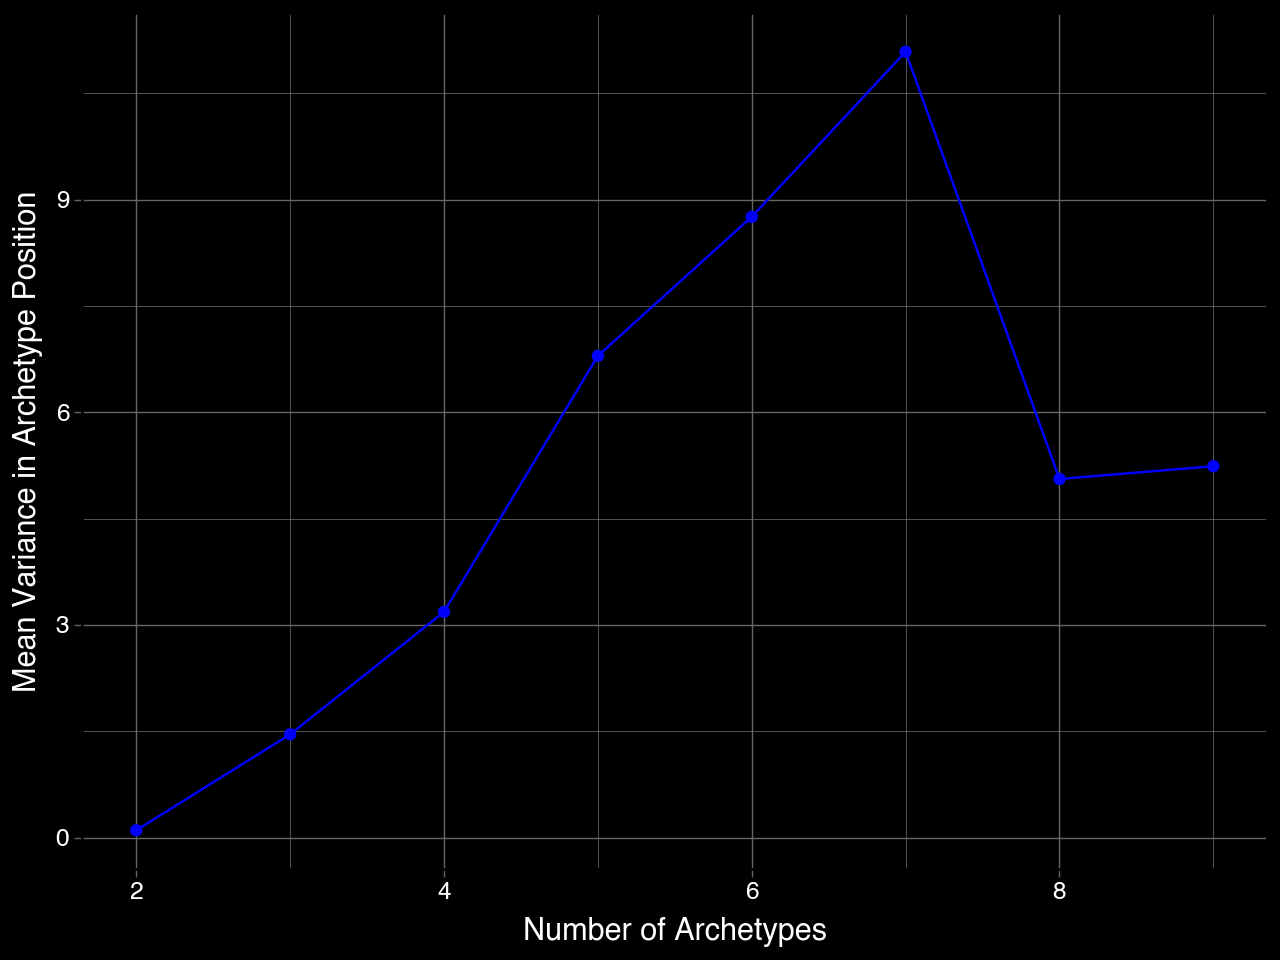

In [8]:
p = bootstrap_variance_k_arr(X, n_bootstrap=10, k_arr=np.arange(2, 10, step=1))
(p + dark_theme).show()

# 3D Plots

In [9]:
bootstrap_df = bootstrap_PCHA(X, n_bootstrap=50, k=n_archetypes, seed=42)
plot_3D_bootstrap(bootstrap_df, color_var="archetype", jitter=0)

In [10]:
X[:, :3].shape

(1224, 3)

In [11]:
A, B, Z, RSS, varexpl = AA(n_archetypes=n_archetypes).fit(X).return_all()
plot_3D(X[:, :3], Z[:, :3])

In [12]:
genes = ["Alb", "Cyp2e1", "Gpx1", "Apoa2"]
gene = "Alb"
expr_vec = adata[:, gene].layers["log1p"].copy().flatten()
plot_3D(X[:, :3], Z[:, :3], color_vec=expr_vec)

# Gene Enrichment Near Archetypes

In [13]:
from scipy.stats import false_discovery_control, mannwhitneyu

dist_mtx = compute_dist_mtx(Z, X)
arg_sorted = np.argsort(dist_mtx, axis=0)
arg_sorted = arg_sorted.T
n_ten_perc = int(np.floor(0.1 * arg_sorted.shape[1]))

enrich_genes_df = []
for arch_idx in range(dist_mtx.shape[1]):
    closest_idx = arg_sorted[arch_idx, :n_ten_perc]
    furthest_idx = arg_sorted[arch_idx, (arg_sorted.shape[1] - n_ten_perc) :]

    closest_expr = adata[closest_idx, :].X.copy()
    closest_expr_mean = closest_expr.mean(axis=0)
    furthest_expr = adata[furthest_idx, :].X.copy()
    furthest_expr_mean = furthest_expr.mean(axis=0)

    res = mannwhitneyu(
        x=closest_expr, y=furthest_expr, alternative="two-sided", method="asymptotic"
    )
    stats, pvals = res.statistic, res.pvalue

    enrich_genes_df.append(
        pd.DataFrame(
            {
                "archetype": arch_idx,
                "gene": list(adata.var_names),
                "pval": pvals,
                "pval_adj": false_discovery_control(pvals, method="bh"),
                "stat": stats,
                "mean_diff": closest_expr_mean / (furthest_expr_mean + 1e-9),
            }
        )
    )
enrich_genes_df = pd.concat(enrich_genes_df, axis=0)
enrich_genes_df = (
    enrich_genes_df.loc[
        np.logical_and(
            enrich_genes_df["pval_adj"] < 0.1, enrich_genes_df["mean_diff"] > 1.3
        ),
        :,
    ]
    .sort_values("mean_diff", ascending=False)
    .copy()
)
enrich_genes_df

,archetype,gene,pval,pval_adj,stat,mean_diff
4850,3,Pparg,4.747858e-11,8.397124e-10,9699.0,3.442623e+08
2988,2,Gtf2e1,6.693213e-05,9.711171e-04,8357.0,1.311475e+08
669,2,Agtpbp1;Nna1,1.214158e-04,1.610533e-03,8296.0,1.311475e+08
6563,3,Traf3,3.963416e-04,1.348601e-03,8174.0,1.065574e+08
5274,3,Rdh1;Rdh9,4.422356e-33,1.530767e-30,13269.5,3.060000e+02
...,...,...,...,...,...,...
5918,3,Slmo2,4.130766e-02,6.901066e-02,8519.5,1.302326e+00
55,2,1190003J15Rik,1.900462e-03,1.454154e-02,9148.0,1.302251e+00
996,3,Atp2a2,4.725941e-03,1.116077e-02,8897.0,1.301887e+00
6782,2,Ugt2a3,7.046104e-04,6.660355e-03,9288.0,1.300971e+00


In [14]:
genes_first = [
    "Alb",
    "Serpinc1",
    "Serping1",
    "Aplp2",  # production andsecretion of plasma proteins
    "G6pc",  # glycogenolysis
]

genes_second = [
    "Glul",
    "Cyp2e1",
    "Cyp1a2",
    "Cyp2a5",
    "Cyp2c37",  # detoxification,
    "Akr1c6",
    "Abcb4",  # bile acid production
    "Hmgcl",  # ketogenesis
    "Blvrb",  # heme synthesis
]

genes_third = [
    "Mgll",
    "Apoa1",
    "Apoa1bp",
    "Apoa2",
    "Apoa5",
    "Apoc1",
    "Apoc3",
    "Apoc4;Apoc2",  # lipid metabolism and transport
    "Hamp",
    "Hp",
    "Ftl1",  # iron homeostasis and storage
    "Aldh2",  # alcoholmetabolism
    "Agt",
    "Igfbp2",
    "Igfbp4",  # hormone synthesis and secretion
]

genes_fourth = [
    "Gpx1",  # glutathione metabolism
    "Pck1",
    "Fbp1",  # gluconeogenesis
    "Cat",  # catalase production
    "Cox7b",
    "Cox5a",
    "Cox6c",
    "Ndufa1",
    "Ndufa5",
    "Ndufb2",  # beta oxidation (cytochrome O oxidase gene family, ubiquinone oxidoreductase subunits)
]

all_genes = genes_first + genes_second + genes_third + genes_fourth

assert np.all([g in list(adata.var_names) for g in all_genes])

In [15]:
enrich_genes_df.loc[np.isin(enrich_genes_df["gene"], genes_first)].sort_values(
    "archetype"
)

,archetype,gene,pval,pval_adj,stat,mean_diff
717,1,Alb,5.457820e-17,8.096509e-15,12060.0,2.036126
2715,1,G6pc,2.353744e-09,1.062693e-07,10702.0,1.980620
2715,2,G6pc,1.505820e-21,3.530904e-19,12591.5,4.278689
717,2,Alb,6.941337e-26,3.363772e-23,13242.0,3.499140
831,2,Aplp2,1.312494e-06,3.245076e-05,10092.0,1.591036
5692,2,Serpinc1,2.970386e-07,8.885488e-06,10267.0,1.479363
5697,2,Serping1,7.947579e-04,7.340655e-03,9290.0,1.309993
831,3,Aplp2,1.022267e-10,1.684706e-09,10982.5,1.949555
5697,3,Serping1,1.183632e-08,1.282239e-07,10584.0,1.582549
5692,3,Serpinc1,2.151492e-07,1.759189e-06,10300.5,1.396677


In [16]:
enrich_genes_df.loc[np.isin(enrich_genes_df["gene"], genes_second)].sort_values(
    "archetype"
)

,archetype,gene,pval,pval_adj,stat,mean_diff
1878,3,Cyp2e1,4.117749e-41,4.988653e-38,14837.0,57.182653
1860,3,Cyp2a5,1.752855e-43,1.274150e-39,14753.0,48.346154
1863,3,Cyp2c37,1.177546e-37,5.706389e-35,13937.0,38.400000
1855,3,Cyp1a2,1.416537e-41,2.059362e-38,14826.0,35.435028
2827,3,Glul,1.089508e-18,6.886635e-17,11934.0,24.052632
707,3,Akr1c6,2.256104e-40,1.490875e-37,14688.5,13.740157
1198,3,Blvrb,7.196398e-36,2.906145e-33,14278.0,7.204545
3139,3,Hmgcl,5.110387e-17,2.517372e-15,12042.0,2.356354
509,3,Abcb4,2.737755e-20,2.094815e-18,12520.0,2.353141


In [17]:
enrich_genes_df.loc[np.isin(enrich_genes_df["gene"], genes_third)].sort_values(
    "archetype"
)

,archetype,gene,pval,pval_adj,stat,mean_diff
3279,0,Igfbp2,3.053071e-07,7.158960e-06,10256.0,2.124101
3046,0,Hamp,2.410071e-08,7.124465e-07,10517.0,1.964781
835,2,Apoa5,5.128861e-04,5.214222e-03,9357.0,1.320555
832,2,Apoa1,4.086663e-07,1.164939e-05,10234.5,1.490668
832,3,Apoa1,1.944532e-07,1.604404e-06,10311.5,1.368985
839,3,Apoc4;Apoc2,5.090143e-08,4.713407e-07,10445.5,1.419804
668,3,Agt,7.807399e-09,8.717662e-08,10622.5,1.586512
3280,3,Igfbp4,9.481645e-13,2.409147e-11,11375.0,1.647271
2691,3,Ftl1,9.939260e-14,2.970714e-12,11544.5,1.752916
724,3,Aldh2,1.437250e-17,7.681888e-16,12143.5,2.243537


In [18]:
enrich_genes_df.loc[np.isin(enrich_genes_df["gene"], genes_fourth)].sort_values(
    "archetype"
)

,archetype,gene,pval,pval_adj,stat,mean_diff
2570,1,Fbp1,4.641840e-14,4.622128e-12,11597.5,1.908845
4544,1,Pck1,3.267098e-09,1.422068e-07,10704.0,1.515420
1720,1,Cox7b,1.523434e-05,2.598909e-04,9822.0,1.454212
2570,2,Fbp1,2.398095e-24,8.715877e-22,13051.5,2.853372
4544,2,Pck1,3.372572e-08,1.297102e-06,10485.0,1.584381
1348,3,Cat,4.043230e-11,7.347560e-10,11080.5,1.643151
2941,3,Gpx1,1.004188e-11,2.097542e-10,11194.0,1.634091
1720,3,Cox7b,4.426201e-07,3.303291e-06,10221.0,1.572890
4203,3,Ndufb2,2.948872e-06,1.783307e-05,10003.5,1.533981
1716,3,Cox6c,2.550917e-06,1.579439e-05,10031.5,1.453159


# T-ratio test

In [19]:
def project_on_polytope(X, Z):
    XC = Z.T
    D, k = X.shape[0], XC.shape[1]
    assert k < (D + 1) and k > 1
    if k == 2:
        proj_vec = (XC[:, 1] - XC[:, 0])[:, None]
    else:
        proj_vec = (XC.T - XC[:, 0])[1:].T
    proj_coord = (
        np.linalg.inv(proj_vec.T @ proj_vec) @ proj_vec.T @ (X - XC[:, 0][:, None])
    )
    proj_X = proj_vec @ proj_coord + +XC[:, 0][:, None]
    # proj_mtx = proj_vec@np.linalg.inv(proj_vec.T@proj_vec)@proj_vec.T
    return proj_coord, proj_X

In [20]:
def compute_t_ratio(X, Z):
    XC = Z.T
    D, k = X.shape[1], XC.shape[1]  # number of PCs, number of archetypes
    if k < D + 1:
        convhull_volume = ConvexHull(project_on_polytope(X, XC.T)[0].T).volume
        polytope_volume = ConvexHull(project_on_polytope(XC.T, XC.T)[0].T).volume
    elif k == D + 1:
        convhull_volume = ConvexHull(X).volume
        polytope_volume = simplex_volume(XC.T)
    elif k > D + 1:
        convhull_volume = ConvexHull(X).volume
        polytope_volume = ConvexHull(XC.T).volume
    return polytope_volume / convhull_volume

In [21]:
compute_t_ratio(X[:, :3], Z[:, :3])

np.float64(0.08406362872578388)

# Enriched Genes Slope

In [22]:
from scipy.stats import linregress, t

dist_mtx = compute_dist_mtx(Z, X).T

In [23]:
def plot_lr(Z, X, arch_idx, gene):
    from scipy.stats import linregress, t

    dist_mtx = compute_dist_mtx(Z, X).T
    dist_vec = dist_mtx[arch_idx, :]
    n = len(dist_vec)
    expr_vec = adata[:, gene].layers["log1p"].copy().flatten()
    lr = linregress(x=dist_vec, y=expr_vec, alternative="two-sided")
    tval = lr.slope / lr.stderr
    pval = 2 * t.cdf(x=-np.abs(tval), df=n - 2, loc=0, scale=1)
    fitted_vals = lr.intercept + lr.slope * dist_vec
    assert np.isclose(pval, lr.pvalue)

    plt.scatter(dist_vec, expr_vec, alpha=0.5)
    plt.plot(dist_vec, fitted_vals, alpha=0.5, color="green")
    plt.xlabel("Distance to Archetype")
    plt.ylabel(f"log1p of scaled fractions of {gene}")
    plt.title(f"archetype: {arch_idx} | gene: {gene} | t-value: {tval:.3f}")
    plt.show()

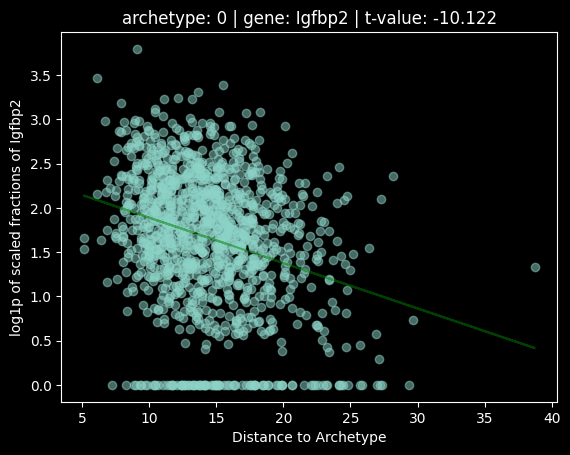

In [24]:
plot_lr(Z, X, 0, "Igfbp2")

In [ ]:
def get_enriched_genes_lr(Z, X, genes):
    from scipy.stats import linregress

    dist_mtx = compute_dist_mtx(Z, X).T

    enrich_genes_df = []
    for arch_idx in range(dist_mtx.shape[0]):
        dist_vec = dist_mtx[arch_idx, :]
        for gene in genes:
            expr_vec = adata[:, gene].layers["log1p"].copy().flatten()
            lr = linregress(x=dist_vec, y=expr_vec, alternative="two-sided")
            tval = lr.slope / lr.stderr

            enrich_genes_df.append(
                pd.DataFrame(
                    {
                        "archetype": [arch_idx],
                        "gene": [gene],
                        "pval": [lr.pvalue],
                        "tval": [tval],
                    }
                )
            )
    enrich_genes_df = pd.concat(enrich_genes_df, axis=0)
    enrich_genes_df["pval_adj"] = false_discovery_control(
        enrich_genes_df["pval"], method="bh"
    )
    return enrich_genes_df

In [26]:
# genes = ["Mgll", "Apoa1", "Apoa1bp", "Apoa2", "Apoa5", "Apoc1", "Apoc3", "Apoc4;Apoc2"]
genes = list(adata.var_names)
enrich_genes_df = get_enriched_genes_lr(Z, X, genes=genes)
# enrich_genes_df

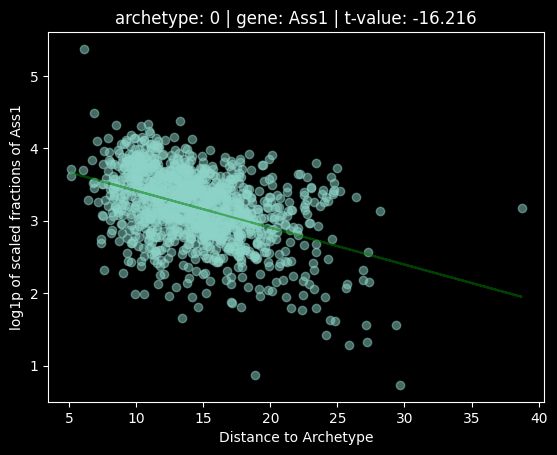

In [27]:
plot_lr(Z, X, 0, "Ass1")

In [28]:
enrich_genes_df.sort_values("tval")

# get the lowest tvalues for each archetype
enrich_genes_df.groupby("archetype").apply(
    lambda x: x.sort_values("tval").head(10)
).reset_index(drop=True)

/var/folders/n8/xnf8qmpj41795tf723xy8mqm0000gn/T/ipykernel_40054/2587780400.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,archetype,gene,pval,tval,pval_adj
0,0,Apoc4;Apoc2,4.246378e-63,-17.783337,9.214007e-61
1,0,Ass1,1.029872e-53,-16.216489,1.793087e-51
2,0,Apoc3,3.594650e-39,-13.569204,3.929250e-37
3,0,Hdmcp;Slc25a47,1.152975e-34,-12.672034,1.102760e-32
4,0,Asl,2.727909e-34,-12.595438,2.566883e-32
5,0,Pigr,6.515571e-34,-12.517639,5.995150e-32
6,0,1100001G20Rik,8.072246e-33,-12.290643,7.090895e-31
7,0,Serpina1e,4.476974e-32,-12.134280,3.828603e-30
8,0,Fxyd1,2.086687e-31,-11.992451,1.743463e-29
9,0,Hp,2.676078e-31,-11.969405,2.216799e-29


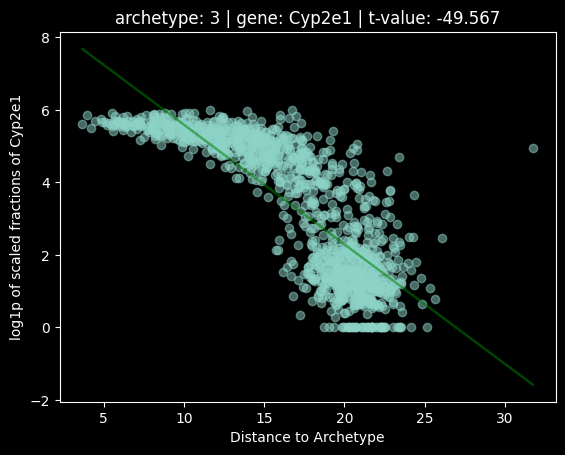

In [29]:
plot_lr(Z, X, 3, "Cyp2e1")

In [30]:
Igfbp2genes = [
    "Mgll",
    "Apoa1",
    "Apoa1bp",
    "Apoa2",
    "Apoa5",
    "Apoc1",
    "Apoc3",
    "Apoc4;Apoc2",
    "",
]
gene = "Apoa5"
arch_idx = 0

dist_vec = dist_mtx[arch_idx, :]
expr_vec = adata[:, gene].layers["log1p"].copy().flatten()
n = len(dist_vec)
lr = linregress(x=dist_vec, y=expr_vec, alternative="two-sided")
tval = lr.slope / lr.stderr
pval = 2 * t.cdf(x=-np.abs(tval), df=n - 2, loc=0, scale=1)
fitted_vals = lr.intercept + lr.slope * dist_vec
assert np.isclose(pval, lr.pvalue)

# plt.scatter(dist_vec, expr_vec, alpha=0.5)
# plt.plot(dist_vec, fitted_vals, alpha=0.5, color="green")
# plt.title(f"t-value: {tval:.3f}")
# plt.show()